In [106]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import ExtraTreesClassifier
import requests
import random
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [173]:
def fig3c_plot_dates_exceeding_avg(dates, filename=False):
    
    df = compile_multiple_dates(dates)
    
    df = df[['mutation', 'date', 'greater_than_average']].copy()
    df = df.pivot(index='mutation', columns='date', values='greater_than_average').fillna(0.0)
    
    myColors = ('white', '#ededed', '#a3cd9c')

    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

    fig, ax = plt.subplots(figsize=(6,12))
    ax = sns.heatmap(df, cmap=cmap, cbar=False)
#     ax = sns.heatmap(df, cmap=sns.color_palette("light:#DB2823", as_cmap=True), cbar=False)
    
#     ax.set_title('Growth rates descending from mutation that are greater than average growth rates')
    ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=16)
    
    for i in range(len(df) + 1):
        ax.axhline(i, color='white', lw=24)
        
#     fewer_than_4_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='fewer than 4 occurrences')
#     blank_line = mpatches.Patch(facecolor='white', edgecolor='white', label='')
    four_or_more_title = mpatches.Patch(facecolor='white', edgecolor='white', label='occurs 4 or more times and:')
    low_growth_rate = mpatches.Patch(color='#ededed', label='descending clades grow slower than average')
    high_growth_rate = mpatches.Patch(color='#a3cd9c', label='descending clades grow faster than average')

    plt.legend(handles=[four_or_more_title, low_growth_rate, high_growth_rate], 
               bbox_to_anchor=(0.55, 1.1), loc='upper center')
    
    ax.tick_params(left=False, bottom=False)
    
    plt.figtext(-0.2, 0.92, 'C', fontsize=24, fontweight='bold')
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')



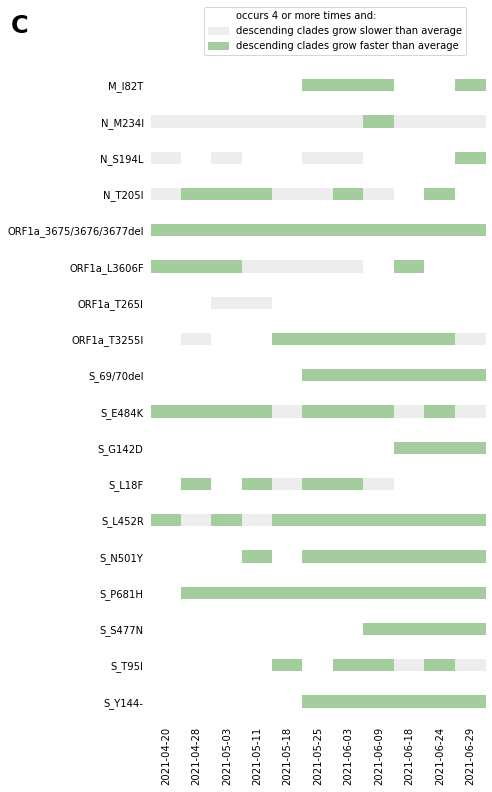

In [175]:
fig3c_plot_dates_exceeding_avg(['2021-04-20', '2021-04-28', 
                 '2021-05-03', '2021-05-11', '2021-05-18', 
                 '2021-05-25', '2021-06-03', '2021-06-09', 
                 '2021-06-18', '2021-06-24', '2021-06-29'], filename='plots/fig3c_time_series.png')

In [176]:
def plot_timeseries(dates):
    
    df = compile_multiple_dates(dates)
    
    # dictionary of list of colors for emerging lineages, depending on total number of lineages
    color_palettes = {8: ['#4068CF','#5098B9','#6CB28C','#94BD62','#BFBB47','#DFA53B','#E67131','#DB2823'], 
                      9: ['#3E5DD0','#4A8CC2','#60AA9E','#80B974','#A6BE55','#CBB742','#E29D39','#E56A2F','#DB2823'], 
                      10: ['#3F52CD','#4681CA','#57A1AD','#70B487','#90BC65','#B4BD4C','#D3B240','#E59638','#E4642E','#DB2823'], 
                      11: ['#3F47C9','#4274CE','#4F97BB','#64AC99','#7EB976','#9EBE5A','#BEBB48','#D9AE3E','#E69036','#E35F2D','#DB2823'], 
                      12: ['#403CC5','#4067CF','#4A8BC3','#5AA4A9','#6FB488','#8BBB69','#A9BD53','#C7B944','#DDA93C','#E68A35','#E35C2C','#DB2823'], 
                      13: ['#4433BE','#3E5ACF','#457FCB','#529AB6','#64AD98','#7BB77A','#96BD60','#B3BD4D','#CDB642','#DFA43B','#E68434','#E2582C','#DB2823'], 
                      14: ['#492AB5','#3F4CCB','#4271CE,''#4C8FC0','#5AA5A8','#6DB38A','#85BA6F','#A0BE59','#BBBC49','#D2B340','#E19F3A','#E68033','#E2562B','#DB2823']
                     }



    # Define the palette as a list to specify exact values
#     palette = sns.color_palette("BuGn_d", n_colors = len(dates))
    palette = color_palettes[len(dates)]


    # Plot the lines on two facets
    sns.relplot(data=df, x="independent_occurrences", y="avg_growth", hue="date", 
                col="mutation", col_wrap = 7,
                kind="scatter", hue_order=dates, palette=palette,
                height=2, aspect=.75, facet_kws=dict(sharex=True, sharey=True)
               ).set_titles("{col_name}"
                           ).set_axis_labels(x_var="", y_var=""
                                                         ).set(xlim=(3.5, 9.5), xticks=[4, 5, 6, 7, 8, 9])


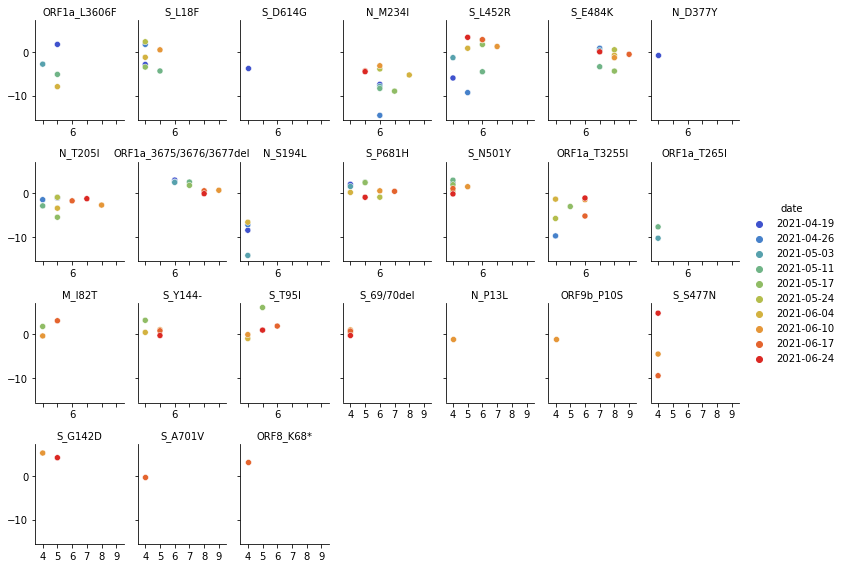

In [177]:
plot_timeseries(['2021-04-19', '2021-04-26', 
                 '2021-05-03', '2021-05-11', '2021-05-17', 
                 '2021-05-24', '2021-06-04', '2021-06-10', 
                 '2021-06-17', '2021-06-24'])

In [178]:
def compile_multiple_dates(dates):
    
    all_dates_info = []
    
    for date in dates:
        all_dates_info.append(top_mutations_and_rates('aa', date))
        
    df = pd.concat(all_dates_info)
    
    return df

In [97]:
def top_mutations_and_rates(mutation_type, date, min_occurrences = 4):
    
    #Download tree json
    tree_url = f"https://data.nextstrain.org/ncov_global_{date}.json"

    tree_json = requests.get(tree_url).json()

    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences(mutation_type, tree)
    
    
    growth_by_precedingmut_dict, s1muts_by_precedingmut_dict = clades_descending_from_mut(mutation_type, 
                                                                                      all_mutations_unique, tree)
    
    convergent_evo_df = convergent_evo_dataframe(mutation_type, growth_by_precedingmut_dict, 
                                                 s1muts_by_precedingmut_dict, independent_occurrences_all_mutations)
    
    # take a subset of the data, only including mutations that appear `min_occurrences` of more times
    convergent_evo_df_zoom = convergent_evo_df.loc[convergent_evo_df['independent_occurrences']>=min_occurrences
                                                  ].reset_index()
    
    # find overall average growth rate at this date
    mean_growth_rate = mean_rate_on_tree(tree)
    convergent_evo_df_zoom['overall_avg_growth'] = mean_growth_rate
    
    convergent_evo_df_zoom['greater_than_average'] = np.where(convergent_evo_df_zoom['avg_growth']>convergent_evo_df_zoom['overall_avg_growth'], 1.0, 0.5)
    
    
    convergent_evo_df_zoom['date'] = date

    return convergent_evo_df_zoom



In [5]:
# make dictionary with gene name as key and reference sequence of that gene as value

reference_sequence = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    for feature in record.features:
        if feature.type == 'CDS':
            gene_seq = feature.location.extract(record.seq).translate()
            reference_sequence[feature.qualifiers['gene'][0]] = gene_seq


/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [6]:
def count_independent_occurrences(mutation_type, tree):
    
    all_mutations = []


    #only look at mutations on internal branches
    for node in tree.find_clades(terminal=False):
        
        # only consider mutations on branches that give rise to a clade of at least 10 tips
        if len(node.get_terminals()) >=10:

            if hasattr(node, 'branch_attrs'):
                for gene, mut_list in node.branch_attrs["mutations"].items():
                    # not considering synonymous mutations for now
                    if gene!= 'nuc':
                        for mut in mut_list:
                            
                            if mutation_type == 'aa':
                                # look at specific nonsyn muts
                                gene_mutation = f'{gene}_{mut}'

                                
                            elif mutation_type == 'site':
                                # look at mutation to a codon (without regard to identity of mutation)
                                gene_mutation = f'{gene}_{mut[1:-1]}'
                            
                            # append mutation to a list of all observed mutations
                            # exclude if mutation is in stop codon position of gene
                            if int(mut[1:-1])!=len(reference_sequence[gene]):
                                all_mutations.append(gene_mutation)
                




    all_mutations_unique = list(set(all_mutations))    

    independent_occurrences_all_mutations = Counter(all_mutations)
    

    return all_mutations_unique, independent_occurrences_all_mutations


In [7]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [27]:
def clades_descending_from_mut(mutation_type, all_mutations_unique, tree):

    #initialize dict for storing all growth rates observed in clades descending from {key} mutation
    growth_by_precedingmut_dict = {k:[] for k in all_mutations_unique}


    #initialize dict for storing S1 mutation counts observed in clades descending from {key} mutation
    s1muts_by_precedingmut_dict = {k:[] for k in all_mutations_unique}



    for node in tree.find_clades():
        
        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=10:
        
            node_path = get_parent(tree, node)


            s1_mutations = None
            if "S1_mutations" in node.node_attrs:
                s1_mutations = node.node_attrs["S1_mutations"]["value"]


            logistic_growth = None
            if "logistic_growth" in node.node_attrs:
                logistic_growth = node.node_attrs["logistic_growth"]["value"]


            for parent in node_path[:-1]:
                if hasattr(parent, 'branch_attrs'):
                    for gene, mut_list in parent.branch_attrs["mutations"].items():
                        if gene!= 'nuc':
                            for mut in mut_list:

                                if mutation_type == 'aa':
                                    # look at specific nonsyn muts
                                    gene_mutation = f'{gene}_{mut}'


                                elif mutation_type == 'site':
                                    # look at mutation to a codon (without regard to identity of mutation)
                                    gene_mutation = f'{gene}_{mut[1:-1]}'


                                # exclude mutations to last codon of gene (stop codon)
                                if int(mut[1:-1])!=len(reference_sequence[gene]):

                                    if logistic_growth!=None:
                                        growth_by_precedingmut_dict[gene_mutation].append(logistic_growth)

                                    if s1_mutations!=None:
                                        s1muts_by_precedingmut_dict[gene_mutation].append(s1_mutations)
                                        
    # get rid of empty entries
    growth_by_precedingmut_dict = {k:v for k,v in growth_by_precedingmut_dict.items() if v}
    s1muts_by_precedingmut_dict = {k:v for k,v in s1muts_by_precedingmut_dict.items() if v}
    
    
    return growth_by_precedingmut_dict, s1muts_by_precedingmut_dict


Find the average logisitic growth rate after a mutation by finding the mean grwoth rate of all clades descending from  branches with that mutation. Do the same for number of S1 mutations. 

Then, make a dataframe where each row is a mutation and columns contain number of independent occurrences, average growth rates, and number of S1 mutations.

In [9]:
def calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict):
    
    # to consider: clade nesting-> just take unique values? 
    # Here, all nested clades are averaging, giving more weight to larger clades
    growth_by_precedingmut_mean = {k:(sum(v)/len(v)) for k,v in growth_by_precedingmut_dict.items()}

    # Here, only unique values are taken, to limit the effect of nesting clades
    growth_by_precedingmut_limit_nesting = {k:list(set(v)) for k,v in growth_by_precedingmut_dict.items()}
    growth_by_precedingmut_limit_nesting_mean = {k:(sum(v)/len(v)) for k,v in growth_by_precedingmut_limit_nesting.items()}

    # this will give more weight to larger clades
    s1muts_by_precedingmut_mean = {k:(sum(v)/len(v)) for k,v in s1muts_by_precedingmut_dict.items() if len(v)!=0}

#     return  growth_by_precedingmut_mean, s1muts_by_precedingmut_mean
    return growth_by_precedingmut_limit_nesting_mean, s1muts_by_precedingmut_mean

In [26]:
def mean_rate_on_tree(tree):
    """
    Finds the mean growth rate of all clades on the tree. 
    Limit nesting, as is done for mutation calculation, by 
    removing duplicate growth rate values
    """
    
    all_growth_rates = []
    for node in tree.find_clades(terminal=False):
        
        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=10:
            if "logistic_growth" in node.node_attrs:
                all_growth_rates.append(node.node_attrs["logistic_growth"]["value"])
                
    all_growth_rates_limit_nesting = list(set(all_growth_rates))
    mean_growth_rate = sum(all_growth_rates_limit_nesting)/len(all_growth_rates_limit_nesting)
    
    return mean_growth_rate


In [23]:
def convergent_evo_dataframe(mutation_type, growth_by_precedingmut_dict, 
                             s1muts_by_precedingmut_dict, independent_occurrences_all_mutations):
    
    growth_by_precedingmut_mean, s1muts_by_precedingmut_mean = calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict)
    
    # make dataframe where each row is a mutation
    # and columns contain number of independent occurrences, average growth rates, and number of S1 mutations

    convergent_evo_list = []

    for mut, occurrences in independent_occurrences_all_mutations.items():
        if mut in s1muts_by_precedingmut_mean.keys():
            avg_s1_muts = s1muts_by_precedingmut_mean[mut]
        else:
            avg_s1_muts = None

        if mut in growth_by_precedingmut_mean.keys():
            avg_growth = growth_by_precedingmut_mean[mut]
        else:
            avg_growth = None



        # for deletions that span multiple consecutive residues, condense this into one row
        if mut == 'ORF1a_S3675-': 
            mut = 'ORF1a_3675/3676/3677del'


        elif mut == 'S_H69-':
            mut = 'S_69/70del'

        if mut not in ['ORF1a_G3676-', 'ORF1a_F3677-', 'S_V70-']:
            convergent_evo_list.append({'mutation': mut, 'independent_occurrences': occurrences, 
                                        'avg_s1_muts': avg_s1_muts, 'avg_growth': avg_growth
                                       })

    convergent_evo_df = pd.DataFrame(convergent_evo_list)

    
    return convergent_evo_df
